<a href="https://colab.research.google.com/github/amenisahmim/customer-segmentation/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation using K-Means

The goal of this notebook is to segment customers from the **Wholesale Customers**
dataset using the **K-Means clustering algorithm**.

Customer segmentation helps identify groups of clients with similar purchasing
behaviors and can be used for:
- targeted marketing,
- business strategy optimization,
- customer behavior analysis.

The workflow of this notebook includes:
1. Data loading and exploration
2. Exploratory Data Analysis (EDA)
3. Data preprocessing and normalization
4. Selection of the optimal number of clusters
5. Clustering with K-Means
6. Cluster visualization
7. Model evaluation
8. Analysis using categorical variables (`Channel`, `Region`)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Wholesale customers data.csv to Wholesale customers data.csv


## 1. Data Loading and Exploration

We start by loading the **Wholesale Customers** dataset and inspecting its structure.
This step helps us:
- understand the available features,
- verify data types,
- detect missing values or duplicates.


In [ ]:
import pandas as pd

df = pd.read_csv("Wholesale customers data.csv")
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## 2. Data Quality Check

We verify:
- the presence of missing values,
- duplicated rows.

Ensuring data quality is essential before applying any clustering algorithm.


In [ ]:
import pandas as pd

# Vérifier si des valeurs manquantes
df.isnull().sum()


,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0
Delicassen,0


In [ ]:
df.duplicated().sum()


np.int64(0)

## 3. Exploratory Data Analysis (EDA)

Exploratory Data Analysis allows us to understand the distribution and relationships
between variables.

We analyze:
- the distribution of customers by `Channel` and `Region`,
- numerical feature distributions,
- outliers using boxplots,
- relationships between variables (e.g., Grocery vs Milk).


/tmp/ipython-input-3664930554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Channel', data=df, palette='viridis')


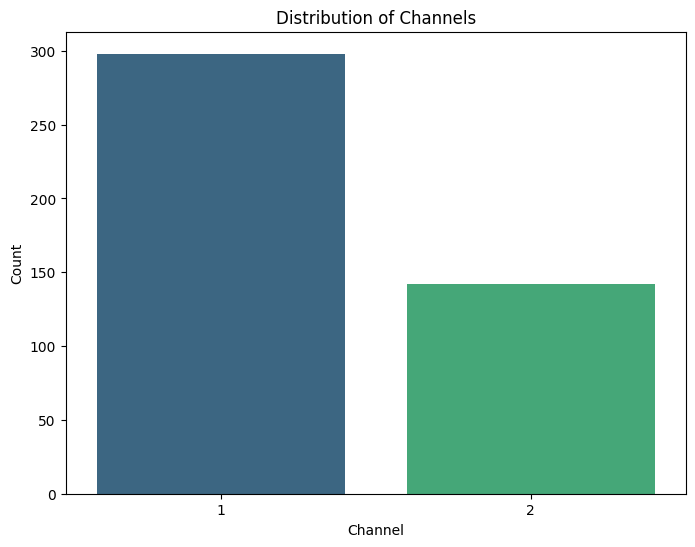

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Channel', data=df, palette='viridis')
plt.title('Distribution of Channels')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()

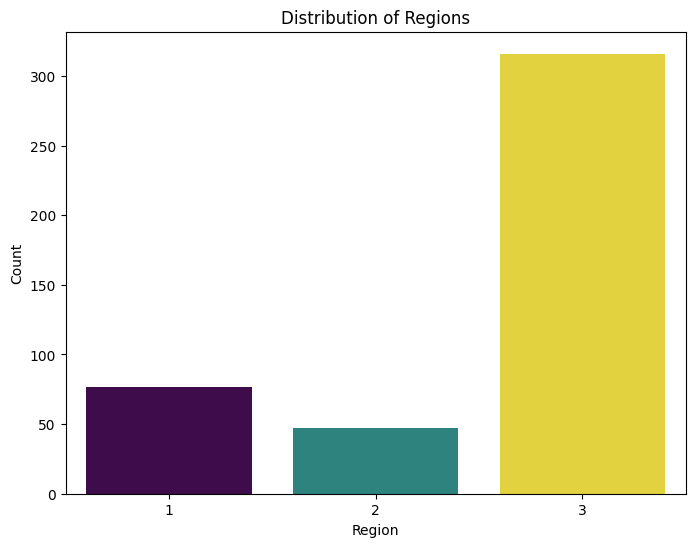

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Region', data=df, palette='viridis', hue='Region', legend=False)
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

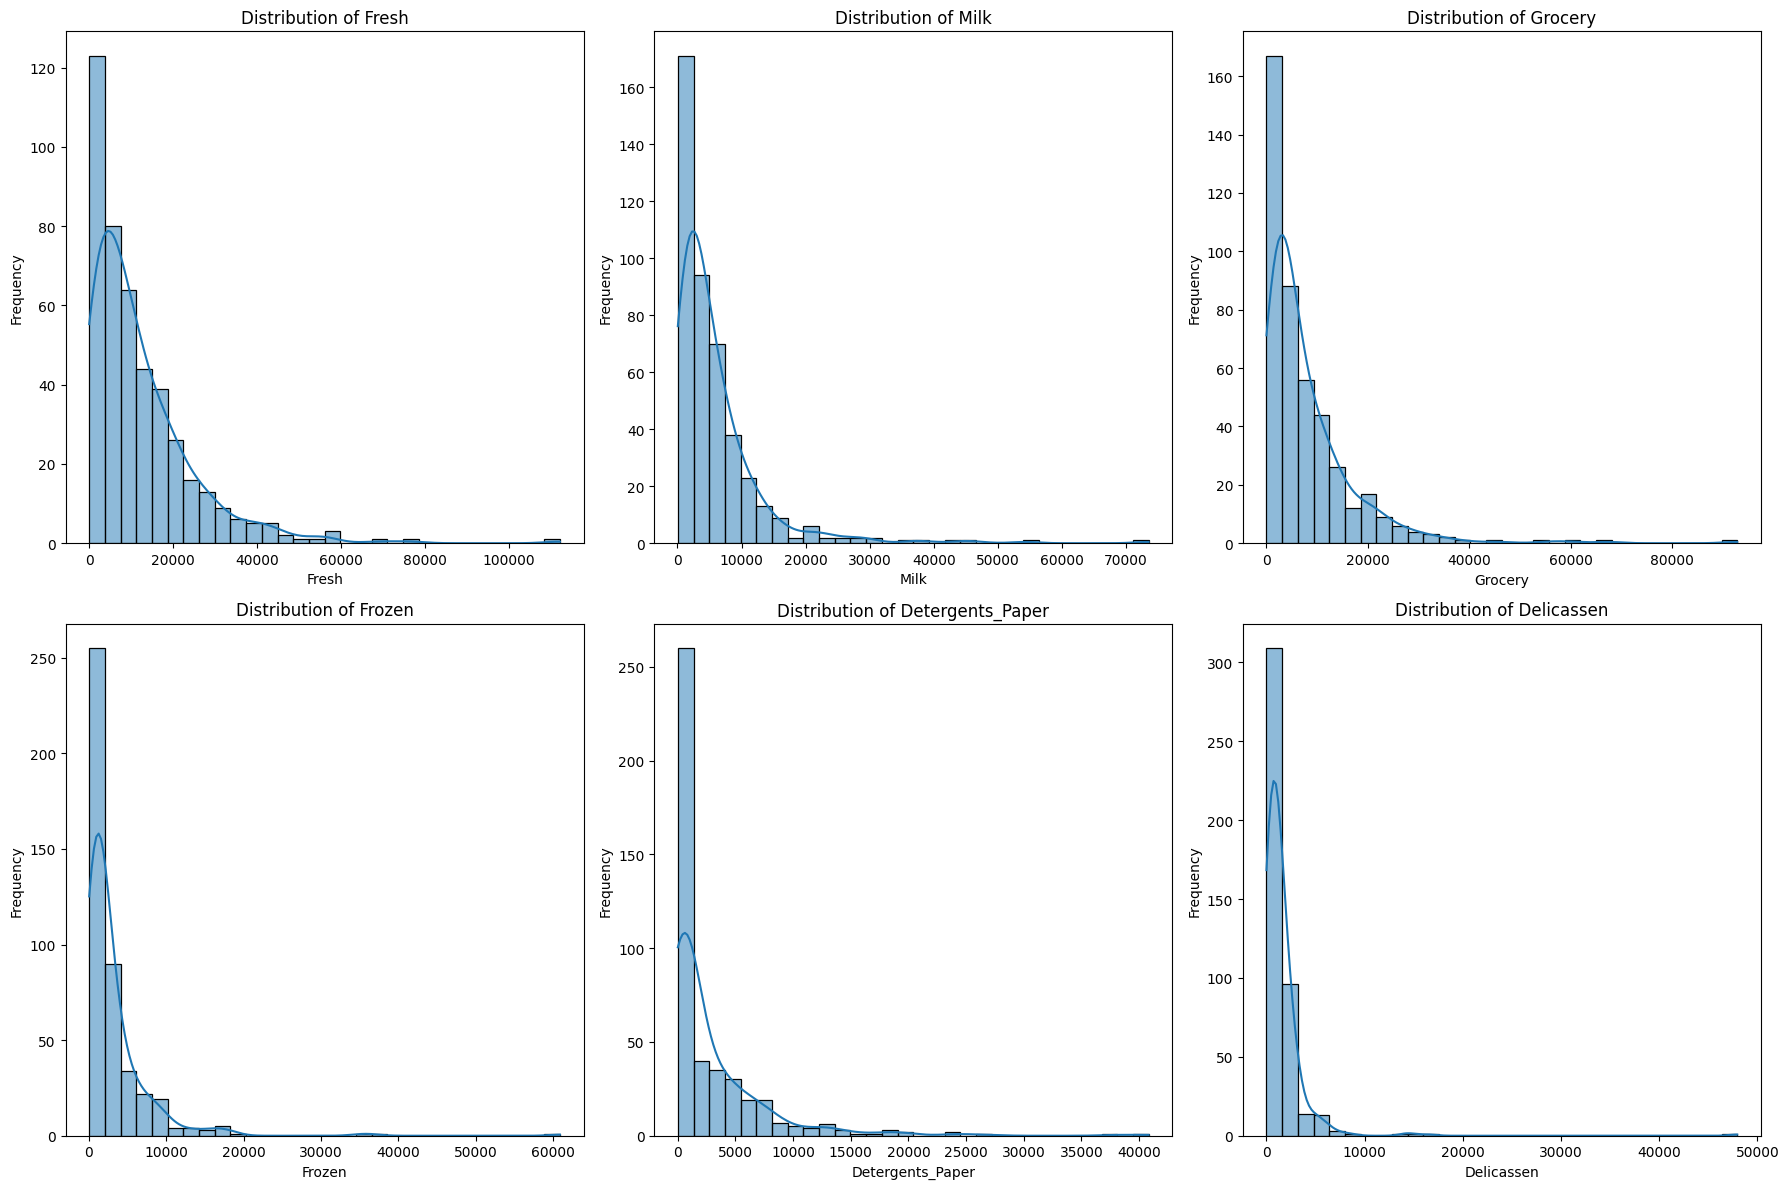

In [ ]:
numerical_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

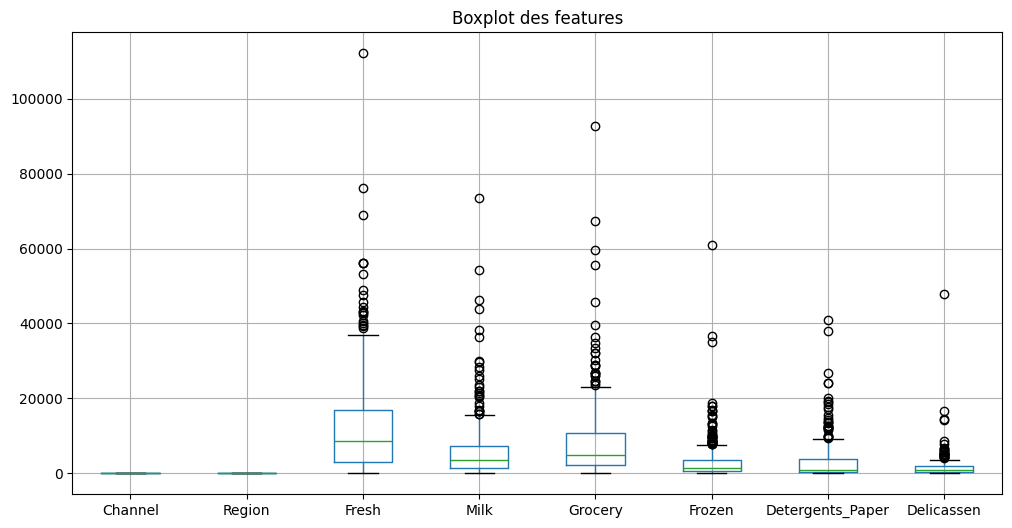

In [ ]:
# Boxplot
df.boxplot(figsize=(12,6))
plt.title("Boxplot des features")
plt.show()


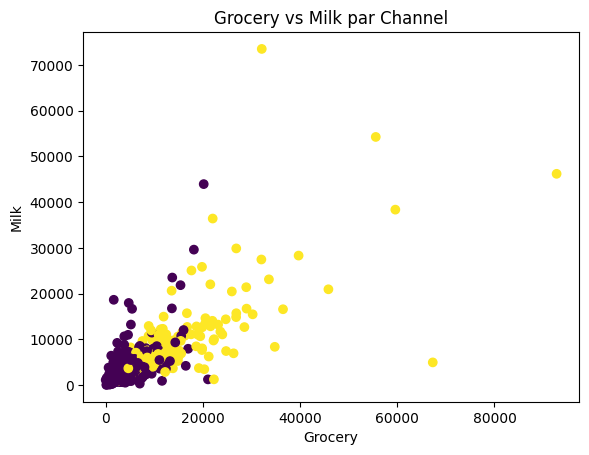

In [ ]:
# Scatter plot exemple
plt.scatter(df['Grocery'], df['Milk'], c=df['Channel'])
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.title('Grocery vs Milk par Channel')
plt.show()

## 4. Feature Scaling

K-Means is a distance-based algorithm and is therefore sensitive to feature scales.

We apply **StandardScaler** to ensure that:
- each feature has a mean of 0,
- a standard deviation of 1.


In [ ]:
from sklearn.preprocessing import StandardScaler

# On prend seulement les colonnes des dépenses pour K-Means
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
import numpy as np
pd.DataFrame(X_scaled, columns=features).describe()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,440.000000,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-3.431598e-17,0.000000,-4.037175e-17,3.633457e-17,2.422305e-17,-8.074349e-18
std,1.001138e+00,1.001138,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-9.496831e-01,-0.778795,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-7.023339e-01,-0.578306,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-2.767602e-01,-0.294258,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,3.905226e-01,0.189092,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,7.927738e+00,9.183650,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


## 5. Optimal Number of Clusters – Elbow Method

The Elbow Method analyzes the evolution of inertia with respect to the number
of clusters.

The point where the inertia reduction slows down indicates a good choice for `k`.


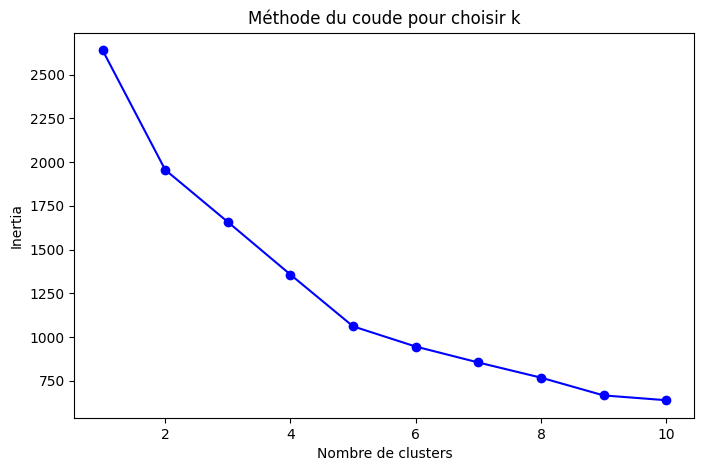

In [ ]:
from sklearn.cluster import KMeans
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertia')
plt.title('Méthode du coude pour choisir k')
plt.show()


## Silhouette Score Analysis

The Silhouette Score measures:
- intra-cluster cohesion,
- inter-cluster separation.

It ranges from -1 to 1.
Higher values indicate better-defined clusters.


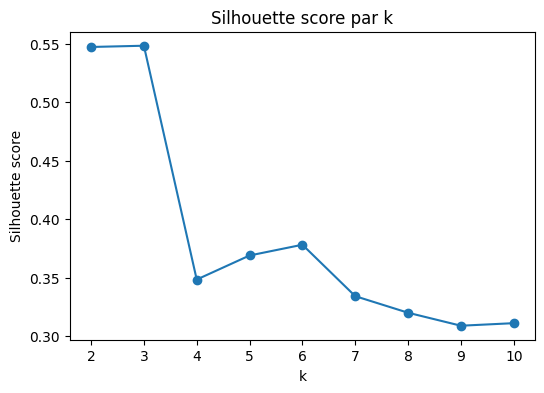

In [ ]:
from sklearn.metrics import silhouette_score
sil = []
for k in range(2,11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2,11), sil, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score par k")
plt.show()

## 6. Applying K-Means

We apply the K-Means algorithm with `k = 2` on the normalized data.
Each customer is assigned to a cluster.


In [ ]:
k_opt = 2  # choisi via coude + silhouette
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df["Cluster"] = labels

# Vérifier la répartition des clusters
print(df['Cluster'].value_counts())


Cluster
0    389
1     51
Name: count, dtype: int64


## 7. Cluster Visualization using PCA

Principal Component Analysis (PCA) is used to reduce the data to two dimensions
for visualization purposes while preserving most of the variance.

PCA is applied only for visualization, not for model training.


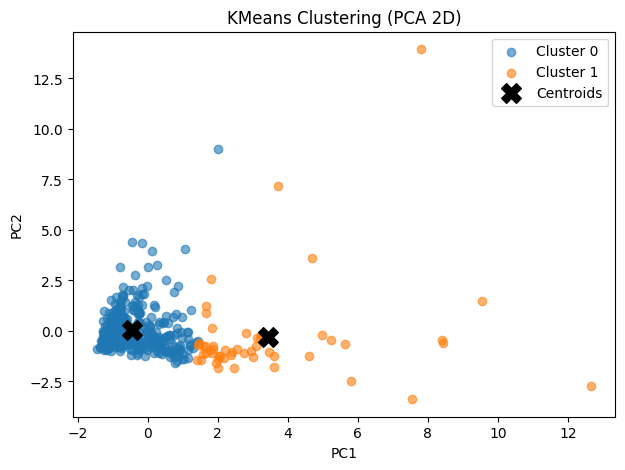

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(7,5))



for cluster in range(k_opt):
    mask = labels == cluster
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f"Cluster {cluster}", alpha=0.6)

centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker="X", s=200, c="black", label="Centroids")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clustering (PCA 2D)")
plt.legend()
plt.show()


6️⃣ Application de K-Means et analyse

In [ ]:
k = 2  # Choisi selon le coude
kmeans = KMeans(n_clusters=k, random_state=0)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Vérifier la répartition des clusters
print(df['Cluster'].value_counts())


Cluster
0    389
1     51
Name: count, dtype: int64


7️⃣ Visualisations des clusters

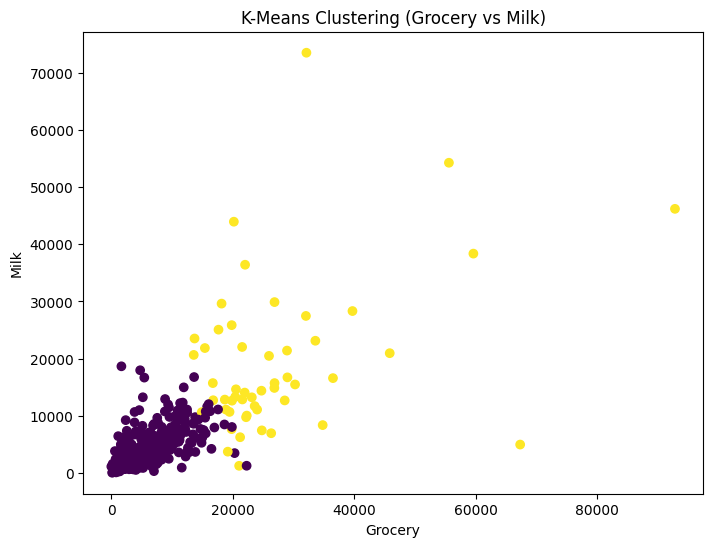

In [ ]:
# Scatter 2D
plt.figure(figsize=(8,6))
plt.scatter(df['Grocery'], df['Milk'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Grocery')
plt.ylabel('Milk')
plt.title('K-Means Clustering (Grocery vs Milk)')
plt.show()



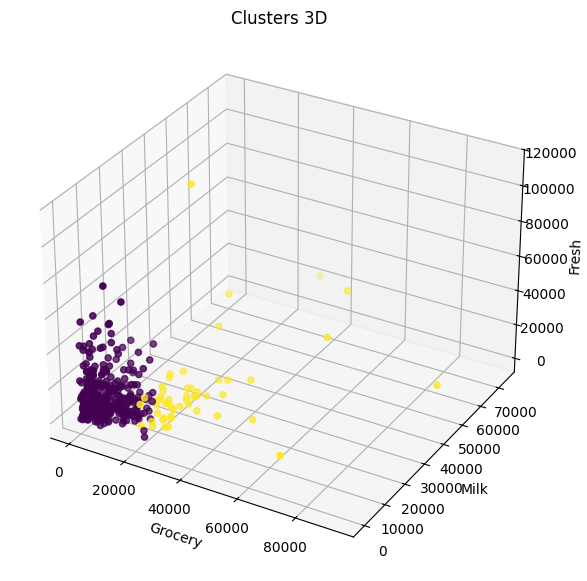

In [ ]:
# Scatter 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Grocery'], df['Milk'], df['Fresh'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('Grocery')
ax.set_ylabel('Milk')
ax.set_zlabel('Fresh')
plt.title('Clusters 3D')
plt.show()


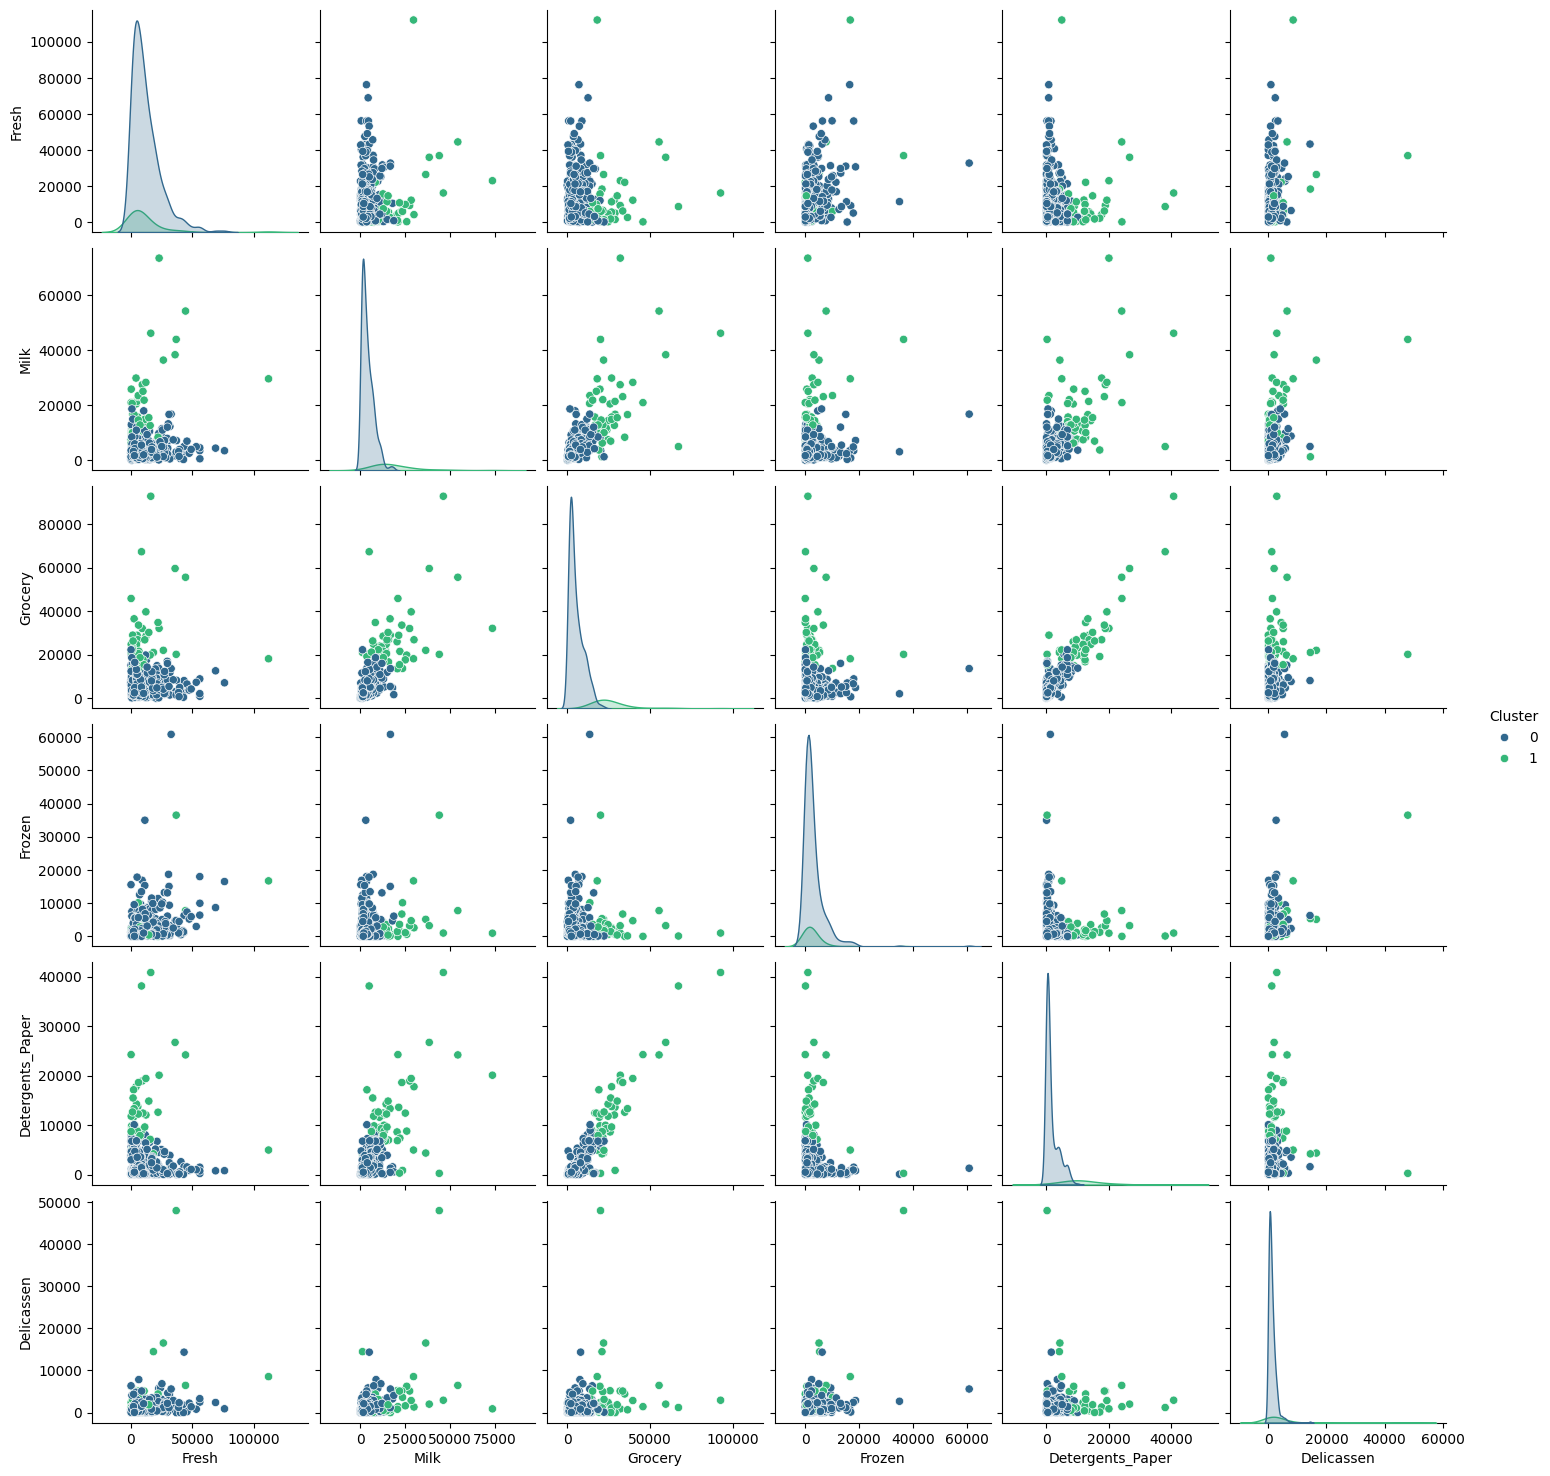

In [ ]:
# Pairplot
sns.pairplot(df, vars=features, hue='Cluster', palette='viridis')
plt.show()

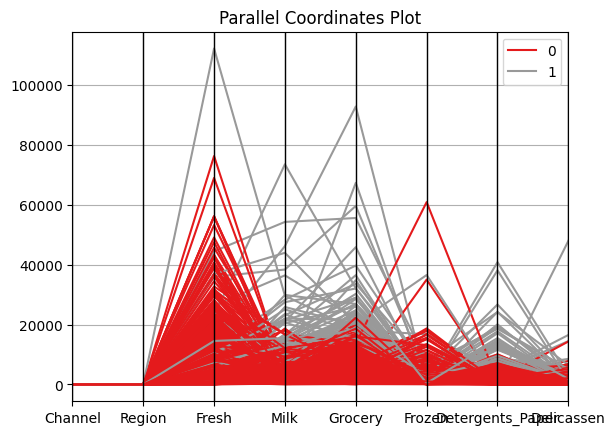

In [ ]:
from pandas.plotting import parallel_coordinates

# Parallel coordinates
parallel_coordinates(df, 'Cluster', colormap=plt.get_cmap("Set1"))
plt.title("Parallel Coordinates Plot")
plt.show()

## 8. Cluster Evaluation

We evaluate the clustering performance using the Silhouette Score.
A positive and relatively high score indicates good cluster separation.


In [ ]:
score = silhouette_score(X_scaled, df['Cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.5472146913441881


## 9. Cluster Analysis using Channel and Region

We analyze the relationship between:
- the clusters generated by K-Means,
- the existing categorical variables (`Channel`, `Region`).

This helps assess whether the clusters have meaningful business interpretations.


In [ ]:
# Cluster vs Channel
print(df.groupby('Cluster')['Channel'].value_counts())

# Cluster vs Region
print(df.groupby('Cluster')['Region'].value_counts())


Cluster  Channel
0        1          293
         2           96
1        2           46
         1            5
Name: count, dtype: int64
Cluster  Region
0        3         282
         1          68
         2          39
1        3          34
         1           9
         2           8
Name: count, dtype: int64


In [ ]:
import pandas as pd
pd.crosstab(df['Channel'], df['Cluster'])

Cluster,0,1
Channel,,
1,293,5
2,96,46


In [ ]:
import pandas as pd

print("Cross-tabulation (Confusion Matrix) for Channel and Cluster:")
print(pd.crosstab(df['Channel'], df['Cluster']))
print("\nCross-tabulation (Confusion Matrix) for Region and Cluster:")
print(pd.crosstab(df['Region'], df['Cluster']))

Cross-tabulation (Confusion Matrix) for Channel and Cluster:
Cluster    0   1
Channel         
1        293   5
2         96  46

Cross-tabulation (Confusion Matrix) for Region and Cluster:
Cluster    0   1
Region          
1         68   9
2         39   8
3        282  34


## 10. Cluster Statistical Summary

We compute:
- the mean spending values per cluster,
- the standard deviation to analyze variability.

This provides a clear profile of each customer segment.


In [ ]:
summary_mean = df.groupby("Cluster")[features].mean().round(2)
summary_std = df.groupby("Cluster")[features].std().round(2)

print("Moyenne des clusters :\n", summary_mean)
print("\nÉcart-type des clusters :\n", summary_std)


Moyenne des clusters :
             Fresh      Milk   Grocery   Frozen  Detergents_Paper  Delicassen
Cluster                                                                     
0        12157.30   4028.17   5402.72  3066.07           1667.69     1256.89
1        10802.76  19282.33  27390.25  3116.67          12139.73     3568.84

Écart-type des clusters :
             Fresh      Milk   Grocery   Frozen  Detergents_Paper  Delicassen
Cluster                                                                     
0        11880.25   3341.63   4372.37  4758.10           2091.47     1355.47
1        17535.71  13481.89  14443.23  5589.35           8170.37     7123.89


In [ ]:
import joblib

joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(scaler, "scaler.pkl")